# 一个端到端的机器学习流程

   一般来说我们可以将一个机器学习任务分为监督学习， 和非监督学习。前者的目的是在给定一个输入变量X（多数情况下是一个由若干变量组成的矩阵）的情况下， 输出一个相应的值y。
如果y是分类变量，比如‘成功’ 或 ‘失败’，当然也可以是更多类别，那么该类型类型的监督学习任务通常被称作为Classification， 即分类。当y是连续的数值型变量时， 那么该类型的监督学习任务通常被称作Regression， 即回归。
   非监督学习， 通常只有X没有y, 这类机器学习任务的目的通常是研究输入向量X自身的特征， 比如通过Clustering analysis（群集分析）去分析X中各种变量的分布特征。比如当X是客户信息时， 通过群集分析以达到对客户进行Segmentation（分层）的目的， 并据此对不同群集的客户进行不同的营销手段。亦或者， 通过关联分析， 去判断不同特征的共现关系（同时出现），其中最有名的就是‘啤酒尿布’的例子。
    

在这个教程中，我会通过一个简单的‘预测房价’问题来展示一个回归类的监督学习的全流程。该教程在很大程度上借鉴了Aurélien Géron的[Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://github.com/ageron/handson-ml)的第二章。在保留主要内容的同时，做了大量的简化，并添加了一些必要的说明，有时间并的朋友建议参看原书。

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

print(sklearn.__version__)

%matplotlib inline

0.19.1


请确保sklearn的版本号大于0.2， 因为本教程中的部分内容只有sklearn2.0以上的版本才能支撑。

## 机器学习的全流程

  机器学习的整个流程大致可以包含以下几个步骤：  
  - 获取数据：不管是从本地还是数据库等
  - 数据查看：对数据由一个基本的认知， 包括数据的类型、数值的分布、数据质量等等
  - 数据清洗：包括Clean，去除脏数据；Correct：由于原始数据经常是人工输入的， 所以难免吗会有错误， 所以需要修正；Convert： 改变数据的类型，比如将字符型数变为数值型数据， 或者反之。
  - 特征工程：可以算作是机器学习流程中最繁杂、耗时最大的一环，特征工程往往需要在原始变量的基础上，往往需要基于不同的问题和特定的领域知识生成一些新的有价值的变量。
  - 建模：基于不同任务选择合适的模型。同时， 如下图所示的那样， 有时会在训练模型的过程中发现一些有价值的信息， 然后可以反作用于特征工程， 然后形成一个互补的循环， 直至模型没办法被改善为止。
  - 预测及部署：部署模型， 并应用于新的数据集， 同时新的数据会带来新的信息， 所以需要不停地去更新模型(当然也可能需要加入新的数据清洗策略及特征工程策略)。

![机器学习流程](../figs/机器学习process.png)

### 获取数据

In [4]:
housing = pd.read_csv('../data/housing.csv')

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
# or
housing.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13896,-116.33,34.15,13.0,1808.0,411.0,735.0,320.0,1.5489,57400.0,INLAND
18977,-122.01,38.25,11.0,6550.0,1149.0,3570.0,1123.0,3.8583,137900.0,INLAND
10588,-117.77,33.69,15.0,500.0,113.0,261.0,116.0,5.0631,154000.0,<1H OCEAN
16529,-121.17,37.82,35.0,2506.0,406.0,1316.0,398.0,3.8472,197600.0,INLAND
9227,-120.05,36.95,18.0,2287.0,534.0,1339.0,505.0,2.2527,65200.0,INLAND


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [13]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
# 明确target  -> median_housing_value
import seaborn as sns

C:\Users\chinaoly\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


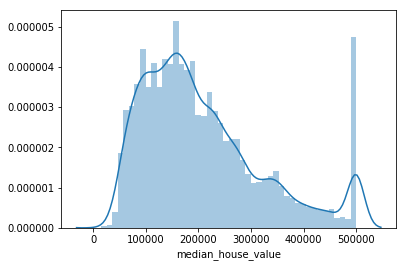

In [9]:
target_col = 'median_house_value'
sns.distplot(housing[target_col])

In [16]:

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [19]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 确定哪些是numeric, 哪些是catagorical 变量
num_attribs = [col for col in housing.columns if col != "ocean_proximity"]
cat_attribs = ["ocean_proximity"]

rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]
    
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)), # validation 会将数据转化成numpy array
        ('std_scaler', StandardScaler()),
    ])

# ColumnTransformer 的意义在与在自定了num col 和catagorial 变量之后， 使得数据转化变得更为简单
full_pipeline = ColumnTransformer([   
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [52]:
mse_real = mean_squared_error(strat_test_set[target_col], test_h)

In [53]:
np.sqrt(mse_real)

66741.36252150308

In [28]:
# model selction 
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [29]:
# 评估模型,  基线模型
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.64295459937

In [30]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49508.082059709115

In [31]:
# 一种更为robust 的评估方式
from sklearn.model_selection import cross_val_score

In [35]:
scores = cross_val_score(lin_reg,housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

In [44]:

np.sqrt(-scores).mean()

68828.99948449328

In [54]:
# 将数据的准备和预测， 用pipleine 
full_pipeline_with_predictor_linear = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor_linear.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbos...'linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [55]:
housing_test = strat_test_set.drop("median_house_value", axis=1)
test_predict =full_pipeline_with_predictor_linear.predict(housing_test)
real_mse_error = np.sqrt(mean_squared_error(strat_test_set[target_col], test_h))

In [56]:
real_mse_error  # 比test error还要低， 这可以算是strait split 的一个好处

66741.36252150308

In [41]:
# 随机森林
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [43]:
score_for = cross_val_score(forest_reg, housing_prepared, housing_labels,  scoring="neg_mean_squared_error", cv=10) 

In [58]:
np.sqrt(-score_for).mean()  # 要远远低于简单显现回归模型的误差

52742.701367175265

In [59]:
full_pipeline_with_predictor_for = Pipeline([
        ("preparation", full_pipeline),
        ("linear", forest_reg)
    ])

full_pipeline_with_predictor_for.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbos...imators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [60]:
test_predict2 = full_pipeline_with_predictor_for.predict(housing_test)

In [64]:
real_mse_error2=np.sqrt(mean_squared_error(strat_test_set[target_col], test_predict2))

In [65]:
#tunning 

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [ ]:
#p